In [29]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [7]:
econ_cities_df = pd.read_csv("data/Econom_Cities_data.csv", sep=";")


### **Предобработка данных**
Посмотрим на данные и произведем все необходимые операции для подготовки их к кластерному анализу


In [8]:
econ_cities_df.head()

,City,Work,Price,Salary
0,Amsterdam,1714,"65,6",49
1,Athens,1792,"53,8","30,4"
2,Bogota,2152,"37,9","11,5"
3,Bombay,2052,"30,3","5,3"
4,Brussels,1708,"73,8","50,5"


Видим, что у `Price` и `Salary` не корректный тип данных, приведем к чисоу с точкой

In [9]:
econ_cities_df['Price'] = pd.to_numeric(econ_cities_df['Price'].astype(str).str.replace(",", "."))
econ_cities_df['Salary'] = pd.to_numeric(econ_cities_df['Salary'].astype(str).str.replace(",", "."))

Посмотрим базовую описательную статистику для полей

In [10]:
econ_cities_df.describe()

,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1384.958333,68.860417,-378.727083
std,2404.897007,21.784659,2027.338052
min,-9999.000000,30.300000,-9999.000000
25%,1740.750000,49.650000,12.250000
50%,1834.500000,70.500000,40.300000
75%,1972.750000,81.700000,58.700000
max,2375.000000,115.500000,100.000000


Видим, что есть отрицательные значения, похоже на ошибки в данных - дайвайте их удалим

In [11]:
numeric_cols = ['Work', 'Price', 'Salary']
econ_cities_df = econ_cities_df[(econ_cities_df[numeric_cols] >= 0).all(axis=1)]

Теперь построим гистограммы для числовых признаков `Price`, `Salary` и `Work`

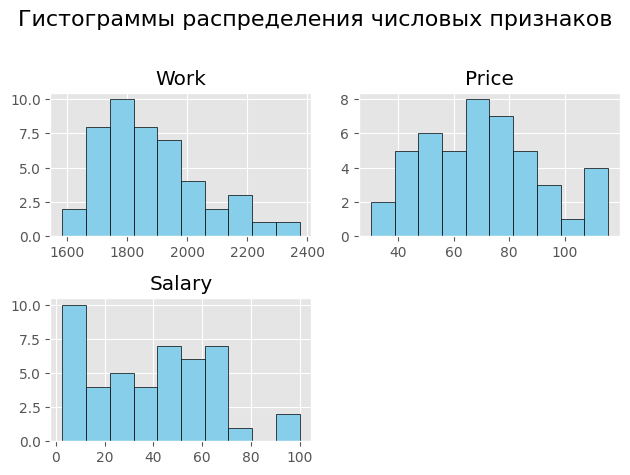

In [12]:
econ_cities_df[numeric_cols].hist(bins=10, color='skyblue', edgecolor='black')

plt.suptitle('Гистограммы распределения числовых признаков', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

Судя по картинке, от выбросов чистить больше не надо - переходим к нормализации.

**Нормализация** нам нужна, так как все алгоритмы, которые мы будем использовать чувствительны к масштабу. Проведем ее с помощью ***StandardScaler*** - среднее в нуле и единичная дисперсия

In [13]:
scaler = StandardScaler()
features_df = econ_cities_df[numeric_cols]
scaled_features = scaler.fit_transform(features_df)

scaled_econ_df = pd.DataFrame(scaled_features, index=features_df.index, columns=features_df.columns)

In [14]:
scaled_econ_df.describe()

,Work,Price,Salary
count,4.600000e+01,4.600000e+01,4.600000e+01
mean,6.365681e-16,-4.247810e-16,1.061952e-16
std,1.011050e+00,1.011050e+00,1.011050e+00
min,-1.721863e+00,-1.881316e+00,-1.504695e+00
25%,-7.809400e-01,-8.662088e-01,-1.027914e+00
50%,-1.792714e-01,4.017885e-02,1.676125e-01
75%,5.586788e-01,5.577770e-01,8.230592e-01
max,2.871116e+00,2.146023e+00,2.468822e+00


Отично, среднее близко к нулю, а СКО к единице. Можено переходить к кластеризации

### Lab 1. Иерархическая кластеризация

> Добавить блок с цитатой



Проведем иерархическую кластеризацию методом Варда

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [50.0, 50.0, 65.0, 65.0],
  [20.0, 20.0, 57.5, 57.5],
  [75.0, 75.0, 85.0, 85.0],
  [80.0, 80.0, 95.0, 95.0],
  [87.5, 87.5, 105.0, 105.0],
  [96.25, 96.25, 115.0, 115.0],
  [38.75, 38.75, 105.625, 105.625],
  [125.0, 125.0, 135.0, 135.0],
  [72.1875, 72.1875, 130.0, 130.0],
  [145.0, 145.0, 155.0, 155.0],
  [150.0, 150.0, 165.0, 165.0],
  [157.5, 157.5, 175.0, 175.0],
  [185.0, 185.0, 195.0, 195.0],
  [190.0, 190.0, 205.0, 205.0],
  [166.25, 166.25, 197.5, 197.5],
  [101.09375, 101.09375, 181.875, 181.875],
  [215.0, 215.0, 225.0, 225.0],
  [220.0, 220.0, 235.0, 235.0],
  [245.0, 245.0, 255.0, 255.0],
  [250.0, 250.0, 265.0, 265.0],
  [227.5, 227.5, 257.5, 257.5],
  [275.0, 275.0, 285.0, 285.0],
  [242.5, 242.5, 280.0, 280.0],
  [295.0, 295.0, 305.0, 305.0],
  [300.0, 300.0, 315.0, 315.0],
  [325.0, 325.0, 335.0, 335.0],
  [307.5, 307.5, 330.0, 330.0],
  [318.75, 3

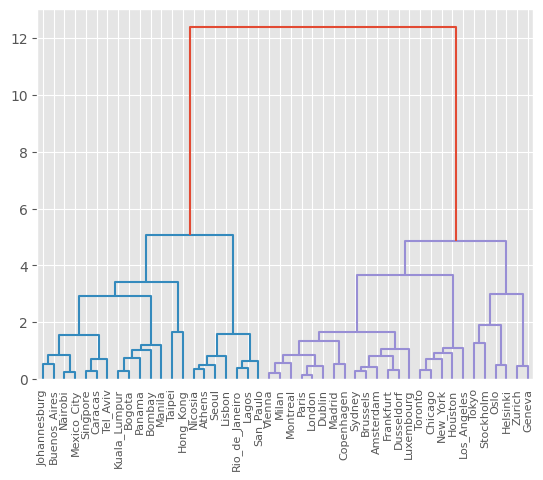

In [15]:
linked = linkage(scaled_econ_df,  'ward', 'euclidean')
dendrogram(linked,
           orientation='top',
           labels=econ_cities_df['City'].tolist(),
           distance_sort='descending')

Выберем k=3 - оптимально между детализацией и простотой и попробуем проинтерпретировать результат

In [16]:
econ_cities_df['cluster'] = fcluster(linked, 3, criterion='maxclust')
cluster_profile = econ_cities_df.groupby('cluster')[numeric_cols].mean()
print(cluster_profile)

                Work      Price     Salary
cluster                                   
1        1789.240000  84.972000  59.032000
2        1798.857143  50.942857  19.214286
3        2082.357143  53.121429  14.914286


Интерпретация

1. **Кластер 1** - это дорогие города, они работают меньше всех, но при этом имеют самые высокие зарплаты
2. **Кластер 2** - похоже, что это города развитых стран, но которые в процессе формирования. Люди работают меньше, при этом цены еще не успели поднятся слишком сильно
3. **Кластер 3** - "бедные" города-  работают больше всех, но при этом получают самые низкие зарплаты

### Lab 2. K-means

Выберем диапазон для количества кластеров - это будет sqrt(n) (в нашем случае n это будет 48 городов)

Далее обучим модель для каждого k и далее с помощью метода локтя и коэффициент силуэта определим оптимальное кол-во *кластеров*


In [18]:
k_range = range(2, 11)

inertia_list = []
silhouette_list = []

In [19]:
for k in k_range:

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_econ_df)

    inertia_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(scaled_econ_df, kmeans.labels_))

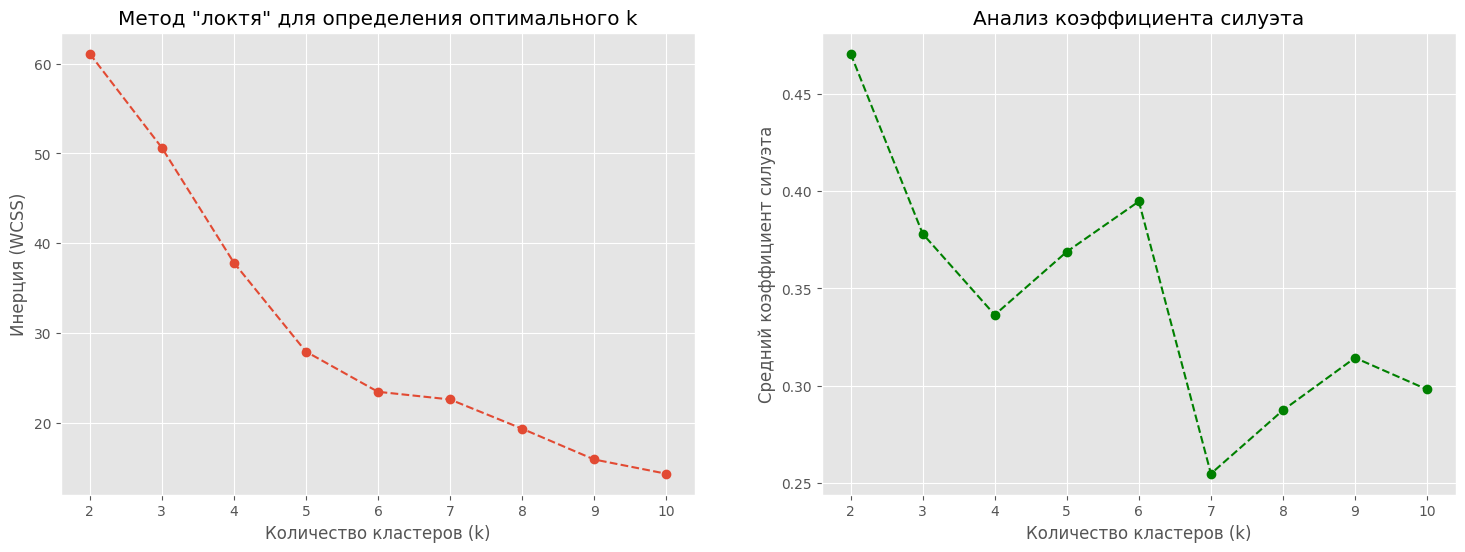

In [20]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Метод "локтя"
ax1.plot(k_range, inertia_list, marker='o', linestyle='--')
ax1.set_xlabel('Количество кластеров (k)')
ax1.set_ylabel('Инерция (WCSS)')
ax1.set_title('Метод "локтя" для определения оптимального k')
ax1.grid(True)

# Коэффициент силуэта
ax2.plot(k_range, silhouette_list, marker='o', linestyle='--', color='green')
ax2.set_xlabel('Количество кластеров (k)')
ax2.set_ylabel('Средний коэффициент силуэта')
ax2.set_title('Анализ коэффициента силуэта')
ax2.grid(True)

plt.show()

In [22]:
K_OPTIMAL = 6

kmeans = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init='auto')
kmeans.fit(scaled_econ_df)

KMeans(n_clusters=6, random_state=42)

In [23]:
cluster_labels = kmeans.labels_
econ_cities_df['cluster_kmeans'] = cluster_labels + 1


--- Количество городов в каждом кластере (k-means) ---
cluster_kmeans
1     8
2     6
3    14
4    12
5     2
6     4
Name: count, dtype: int64


--- Профили кластеров (k-means, k=6) ---
                   Work   Price  Salary
cluster_kmeans                         
1               2146.88   48.76   12.41
2               1990.83   77.23   55.32
3               1732.00   78.14   53.61
4               1868.75   52.16   17.46
5               1874.00   97.95   95.15
6               1733.75  113.85   59.38


In [25]:
econ_cities_df['cluster_kmeans'].value_counts().sort_index()

,count
cluster_kmeans,
1,8
2,6
3,14
4,12
5,2
6,4


In [26]:
cluster_profile_kmeans = econ_cities_df.groupby('cluster_kmeans')[numeric_cols].mean()

In [28]:
cluster_profile_kmeans.round(2)

,Work,Price,Salary
cluster_kmeans,,,
1,2146.88,48.76,12.41
2,1990.83,77.23,55.32
3,1732.00,78.14,53.61
4,1868.75,52.16,17.46
5,1874.00,97.95,95.15
6,1733.75,113.85,59.38


Теперь проанализируем кластеры
-  **Кластер 1** - города с низкой стоимостью жизни. Самые высокие работчее время + самые низкие цены и зарплаты
-  **Кластер 2** - высокое время работы при этом цены и запрплаты средние или выше среднего. Это города развитых стран, но которые находятся где-то на середине, возможно с сильными финансовыми центрами
- **Кластер 3** - самая середина. Развитые страны со средней зп, никто не перерабатывает и цены стабильные
- **Кластер 4** - города на середине между средними и самыми бедными, в которых происходит переходный этап экономики
- **Кластер 5** - самые богатые города c самым высоким уровеним жизни (наибольшая зп), при этом цены не самые высокие но держат планку. А работают здесь не много и не мало
- **Кластер 6** - города также с очень высоким уровнем жизни, но здесь на порядок выше цены, хоть и зп ниже чем в кластере 5. Это похоже на крупные мегаполисы

### Lab 3. DBSCAN


Самое важное подобрать гиперпараметры для DBSCAN, а именно *min_samples* и *eps_optimal*.
*min_samples* берется не меньше чем `кол-во признаков + 1` (в нашем случае не менее 4). Давайте возьмем 5

Далее для подбора *eps* будем использовать метод k-соседей. В нашем случае до 4-го ближайшего соседа, так как `k = min_samples - 1`. Далее строим график - там где видим резкое увеличение - это и будет наше оптимальное значени *eps*

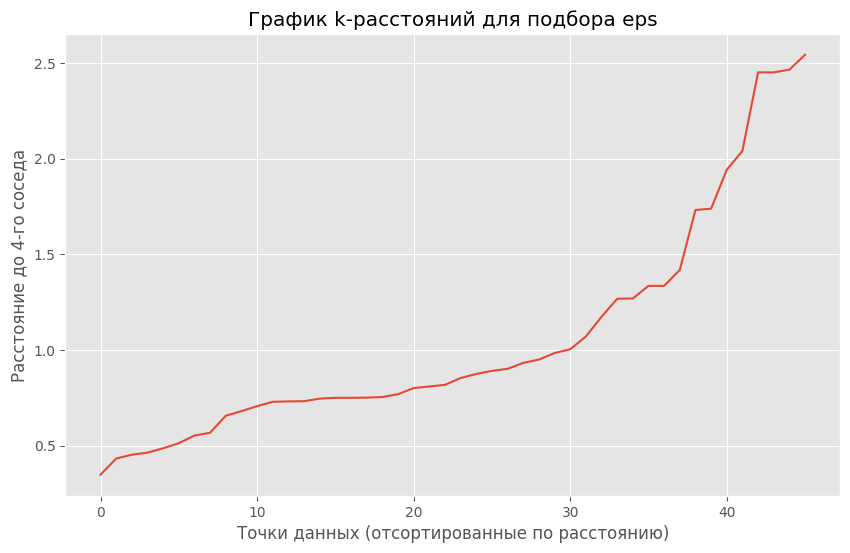

In [30]:
MIN_SAMPLES = 5

neigh = NearestNeighbors(n_neighbors=MIN_SAMPLES)
neigh.fit(scaled_econ_df)

distances, indices = neigh.kneighbors(scaled_econ_df)

distances = np.sort(distances[:, MIN_SAMPLES-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('График k-расстояний для подбора eps')
plt.xlabel('Точки данных (отсортированные по расстоянию)')
plt.ylabel(f'Расстояние до {MIN_SAMPLES-1}-го соседа')
plt.grid(True)
plt.show()

Из графика мы отчетливо видим, что значение резко возрастает после 1.4. Выберем это значение как eps

In [35]:
# На основе графика k-расстояний
EPS_OPTIMAL = 1.4

dbscan = DBSCAN(eps=EPS_OPTIMAL, min_samples=MIN_SAMPLES)
dbscan.fit(scaled_econ_df)

cluster_labels_dbscan = dbscan.labels_
econ_cities_df['cluster_dbscan'] = cluster_labels_dbscan

n_clusters = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
n_noise = list(cluster_labels_dbscan).count(-1)

print(f"DBSCAN нашел {n_clusters} кластеров")
print(f"Количество выбросов (шума): {n_noise}")
print("\nРаспределение по кластерам:")
print(econ_cities_df['cluster_dbscan'].value_counts())

DBSCAN нашел 3 кластеров
Количество выбросов (шума): 7

Распределение по кластерам:
cluster_dbscan
 0    20
 1    12
 2     7
-1     7
Name: count, dtype: int64


Модель нашла 7 выбросов (кластер -1) и 3 кластера

In [36]:
dbscan_results = econ_cities_df.copy()

# Исключаем шумовые точки для анализа профилей
if n_clusters > 0 and -1 in econ_cities_df['cluster_dbscan'].unique():
    cluster_profile_dbscan = dbscan_results[dbscan_results['cluster_dbscan'] != -1].groupby('cluster_dbscan')[['Work', 'Price', 'Salary']].mean()
    print("\n--- Профили найденных кластеров (DBSCAN) ---")
    print(cluster_profile_dbscan.round(2))

# Посмотрим, что из себя представляют "выбросы"
if n_noise > 0:
    print("\nГорода, определенные как шум (выбросы)")
    print(econ_cities_df[econ_cities_df['cluster_dbscan'] == -1])


--- Профили найденных кластеров (DBSCAN) ---
                   Work  Price  Salary
cluster_dbscan                        
0               1809.65  77.86   54.12
1               1868.75  52.16   17.46
2               2114.29  46.61   10.21

Города, определенные как шум (выбросы)
         City  Work  Price  Salary  cluster  cluster_kmeans  cluster_dbscan
13     Geneva  1880   95.9    90.3        1               5              -1
14   Helsinki  1667  113.6    66.6        1               6              -1
15  Hong_Kong  2375   63.8    27.8        3               1              -1
33       Oslo  1583  115.5    63.7        1               6              -1
40  Stockholm  1805  111.3    39.2        1               6              -1
44      Tokyo  1880  115.0    68.0        1               6              -1
47     Zurich  1868  100.0   100.0        1               5              -1


DBSCAN определил некоторые страны как выбросы. Например, Цюрих и Женева имеют экстремально высокие зарплаты, а Гонг Конг очень высокую рабочую нагрузку.

**Анализ по кластерам**:
- **Кластер 1** - города в развитых странах с высокими ценами и выоской зп. Тут зп отличается от остальных кластеров более чем в 3 раза
- **Кластер 2** - города с переходной экономикой - работают столько же сколько первый кластер, но зп сильно ниже но и цены ниже но не пропорционально
- **Кластер 3** - активно работающие города, но с низким уровнем жизни - низкие зп, а цены не сильно ниже чем в остальных кластерах